### **Business IT Alignment Dynamics**  
The proposed model describes how alignment evolves in an organization using the discrete-time equation:  

$$
x_{t + 1} = x_t + A(x_t) - B(x_t)C(x_t)
$$
                    
Where A, B, C are defined as:  
- $ A(x_t) = d(1 - x_t) $
- $ B(x_t) = \frac{a x_t (1 - x_t)^g}{1 + a h x_t} $ 
- $ C(x_t) = \frac{1}{1 + z^s} $ where $ z = \frac{r (1 - x_t)}{x_t (1 - r)} $
        
#### **Variables and Terms**  
| **Term**       | **Description**                                                                                          | **Key Factors**                                                                 |
|----------------|----------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| **$x_t$**   | Percentage of dissatisfied end users (proxy for misalignment).                                           | State variable representing current alignment level.                           |
| **$A(x_t)$**| **Environmental pressure effect**: Captures how external dynamics (competition, tech obsolescence) increase misalignment. | $d$: Environmental dynamicity.                              |
| **$B(x_t)$**| **IT department efficacy**: Capacity to translate business needs into IT solutions.                      | $a$: IT department efficacy. <br> $h$: IT system rigidity. <br> $g$: IT investment propensity. |
| **$C(x_t)$**| **Organizational adaptability**: Capacity of the organization to adopt and exploit new IT solutions.     | $r$: Activation threshold for change. <br> $s$: Organizational flexibility. |

#### **Ranges and defaults**
| Parameter | Interpretation              | Range           | Default Value |
|-----------|-----------------------------|-----------------|---------------|
| **$x_0$** | Initial misalignment        | [0.01, 0.99]    | 0.3           |
| **$d$**   | Environmental dynamicity    | [0.01, 10]      | 0.5           |
| **$a$**   | IT department efficacy      | [0.1, 10]       | 2             |
| **$g$**   | IT investment propensity    | [0.1, 5]        | 1             |
| **$h$**   | IT system rigidity          | [0.1, 5]        | 1             |
| **$r$**   | Action threshold            | [0.01, 0.99]    | 0.3           |
| **$s$**   | Organizational flexibility  | [1, 10]         | 3             |


In [ ]:
import numpy as np
import matplotlib.pyplot as plt     
from ipywidgets import interact, FloatSlider, IntSlider, Layout
from IPython.display import display
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [ ]:
def A(x, d):
    return d * (1 - x)


def B(x, a, h, g):
    return (a * x * (1 - x) ** g) / (1 + a * h * x)


def C(x, r, s):
    if x == 0:  # Avoid 0 division error
        return 0

    term1 = r * (1 - x)
    term2 = (1 - r) * x
    return 1 / (1 + (term1 / term2) ** s)


def delta(x, d, a, h, g, r, s):
    return A(x, d) - B(x, a, h, g) * C(x, r, s)

default_params = {
    "x0": 0.3,
    "steps": 100,
    "d": 0.5,
    "a": 2,
    "h": 1,
    "g": 1,
    "r": 0.3,
    "s": 3,
}

def simulate(x0, d, a, h, g, r, s, steps=50):
    x = np.zeros(steps)
    x[0] = x0

    for t in range(steps - 1):
        x[t + 1] = x[t] + delta(x[t], d, a, h, g, r, s)
        x[t + 1] = np.clip(x[t + 1], 0, 1)

    return x



# Interactive Long-Term Simulation
This diagram visualizes the system's temporal evolution for a specified number of steps based on initial dissatisfaction (x₀) and model parameters. By adjusting the sliders, you can explore how different conditions affect the system's behavior over time.

Additionally it classifies the equation qualitative behavior (e.g., chaotic, converging, oscillating) based on *stability* analysis.

In [ ]:
slider_style = {"description_width": "80px"}
slider_layout = Layout(width="50%")


@interact(
    x0=FloatSlider(
        min=0,
        max=1,
        step=0.01,
        value=default_params["x0"],
        description="x₀",
        style=slider_style,
        layout=slider_layout,
    ),
    steps=IntSlider(
        min=10,
        max=200,
        step=10,
        value=default_params["steps"],
        description="Steps",
        style=slider_style,
        layout=slider_layout,
    ),
    d=FloatSlider(
        min=0,
        max=10,
        step=0.1,
        value=default_params["d"],
        description="d",
        style=slider_style,
        layout=slider_layout,
    ),
    a=FloatSlider(
        min=0,
        max=10,
        step=0.1,
        value=default_params["a"],
        description="a",
        style=slider_style,
        layout=slider_layout,
    ),
    h=FloatSlider(
        min=0,
        max=5,
        step=0.1,
        value=default_params["h"],
        description="h",
        style=slider_style,
        layout=slider_layout,
    ),
    g=FloatSlider(
        min=0,
        max=5,
        step=0.1,
        value=default_params["g"],
        description="g",
        style=slider_style,
        layout=slider_layout,
    ),
    r=FloatSlider(
        min=0.1,
        max=0.9,
        step=0.1,
        value=default_params["r"],
        description="r",
        style=slider_style,
        layout=slider_layout,
    ),
    s=FloatSlider(
        min=1,
        max=10,
        step=0.5,
        value=default_params["s"],
        description="s",
        style=slider_style,
        layout=slider_layout,
    ),
)
def run_simulation(steps, x0, d, a, h, g, r, s):
    x_values = simulate(x0, d, a, h, g, r, s, steps)

    plt.figure(figsize=(18, 6))
    ax = plt.gca()

    plt.plot(
        x_values,
        "b-o",
        markersize=6,
        linewidth=2,
        markerfacecolor="white",
        markeredgewidth=1.5,
    )

    plt.xlabel("Iteration (t)", fontsize=12, labelpad=10)
    plt.ylabel("Dissatisfaction (x)", fontsize=12, labelpad=10)
    plt.title("Business-IT Alignment Dynamics", fontsize=14, pad=20)

    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.ylim(0, 1)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()

    plt.show()

    last_values = x_values[-10:]
    if np.std(last_values) < 0.001:
        final_val = np.mean(last_values)
        if final_val < 0.1:
            print(f"→ System converges to ALIGNED state (x = {final_val:.3f})")
        elif final_val > 0.9:
            print(f"→ System converges to MISALIGNED state (x = {final_val:.3f})")
        else:
            print(f"→ System converges to PARTIAL alignment (x = {final_val:.3f})")
    else:
        if len(np.unique(np.round(last_values, 2))) > 3:
            print("→ Chaotic behavior detected")
        else:
            print("→ System oscillates between states")

interactive(children=(IntSlider(value=100, description='Steps', layout=Layout(width='50%'), max=200, min=10, s…

# Phase Portrait

This interactive diagram visualizes the system's dynamics by plotting the rate of change (dx/dt) against misalignment (x). Adjust parameters to explore how different conditions affect the system's long-term behavior and stability properties. \
Arrows indicate direction of change, while color intensity reflects speed. Stable and unstable equilibria appear where the curve crosses zero. 


In [ ]:
def phase_portait(d, a, h, g, r, s, x_range=(0, 1), n_points=100):
    x = np.linspace(x_range[0], x_range[1], n_points)
    dx = np.array([delta(xi, d, a, h, g, r, s) for xi in x])
    
    plt.figure(figsize=(14, 6))
        
    # Plot 20 arrows evenly spaced for the derivative, letting color represent the intensity. 
    arrow_indices = np.linspace(0, len(x)-1, 20, dtype=int)
    arrow_x = x[arrow_indices]
    arrow_dx = dx[arrow_indices]
    
    norm = Normalize(vmin=0, vmax=np.max(np.abs(dx)))
    cmap = plt.cm.RdYlBu_r
    
    arrow_length = 0.02 
    arrow_head_width = 0.005
    arrow_head_length = 0.008
    arrow_y_pos = 0
    
    for xi, dxi in zip(arrow_x, arrow_dx):
        color = cmap(norm(np.abs(dxi)))
        if dxi > 0:
            plt.arrow(xi, arrow_y_pos, arrow_length, 0, 
                     head_width=arrow_head_width, 
                     head_length=arrow_head_length,
                     fc=color, ec=color, 
                     width=0.0001,
                     length_includes_head=True,
                     alpha=0.9)
        elif dxi < 0:
            plt.arrow(xi, arrow_y_pos, -arrow_length, 0,
                     head_width=arrow_head_width,
                     head_length=arrow_head_length,
                     fc=color, ec=color,
                     width=0.0001,
                     length_includes_head=True,
                     alpha=0.9)
    
    plt.plot(x, dx, 'k-', linewidth=1.5, alpha=0.7, label='dx/dt')
    
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical',
                        pad=0.05, shrink=0.8)
    cbar.set_label('Speed of Change (|dx/dt|)', labelpad=15)
    
    plt.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    plt.xlabel('x (Misalignement)', fontsize=11, labelpad=12)
    plt.ylabel('dx/dt', fontsize=11, labelpad=12)
    plt.title(f'ODE Phase Portrait', fontsize=13, pad=15)
    
    y_max = np.max(np.abs(dx)) * 1.1
    plt.ylim([-y_max, y_max])
    
    plt.grid(True, linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.show()

slider_style = {'description_width': '100px'}

@interact(
    d=FloatSlider(min=0, max=10, step=0.1, value=default_params['d'], description='d',
                style=slider_style, layout=slider_layout ),
    a=FloatSlider(min=0, max=10, step=0.1, value=default_params['a'], description='a',
                style=slider_style, layout=slider_layout ),
    h=FloatSlider(min=0, max=5, step=0.1, value=default_params['h'], description='h',
                style=slider_style, layout=slider_layout ),
    g=FloatSlider(min=0, max=5, step=0.1, value=default_params['g'], description='g',
                style=slider_style, layout=slider_layout ),
    r=FloatSlider(min=0.1, max=0.9, step=0.1, value=default_params['r'], description='r',
                style=slider_style, layout=slider_layout ),
    s=FloatSlider(min=1, max=10, step=0.5, value=default_params['s'], description='s',
                style=slider_style, layout=slider_layout ),
)
def update_plot(d, a, h, g, r, s):
    phase_portait(d, a, h, g, r, s)

interactive(children=(FloatSlider(value=0.5, description='d', layout=Layout(width='50%'), max=10.0, style=Slid…

# Interpreting the equation

$$
x_{t + 1} = x_t + \underbrace{A(x_t)}_{\text{Pressure}} - \underbrace{B(x_t)C(x_t)}_{\text{Recovery}}
$$

**$x_t$ - Alignement**\
Measures the percentage of dissatisfied users (proxy for Business-IT misalignment) at time $t$.  
+ $0$ = complete satisfaction
+ $1$ = utter dissatisfaction

**$A(x_t)$ - Environmental Pressure**\
*Increases* misalignment due to external factors. It represents how competitive environment and technological changes create alignment challenges.

**$B(x_t) \cdot C(x_t)$ - Recovery Mechanism**\
*Reduces* misalignment through $B(x_t)$ (IT department's effectiveness) and $C(x_t)$ (organization's adaptability).  

## Understanding the parameters

[Desmos simulation](https://www.desmos.com/calculator/qbybvtimtd).

### Environmental pressure
$ A(x_t) = d(1 - x_t) $ 

This is a line passing through the point (1, 0) with a slope of $-d$. 

- **d (dynamicity)**: fast changing industries (e.g., a tech startup) have a competition/innovation that rapidly renders old IT systems obsolete.
- **$1 - x_t$**: as misalignment grows, environmental pressure has less "room" to worsen things. 
  
### IT Department Efficacy
$ B(x_t) = \frac{a x_t (1 - x_t)^g}{1 + a h x_t} $ 

This looks like a function that peaks at some $x_a$ and then tapers off.
- **a (IT efficacy)**: an higher a can more effectively reduce misalignment.
- **x (current misalignment)**: the more misalignment exists, the more opportunity/pressure there is for IT to act.
- **$(1−x_t​)^g$ (Diminishing Returns)**: as satisfaction improves, the IT department's impact diminishes. 
  - I haven't understood g. 
- **$1 + ahx_t$ (Saturation)**: even if IT is highly capable (a >> 1), inflexible systems (h >> 1) limit its efficacy.

### Organizational Adaptability
$ C(x_t) = \frac{1}{1 + z^s} $ where $ z = \frac{r (1 - x_t)}{x_t (1 - r)} $

This is a **sigmoid** function in disguise. Sigmoids are great for modeling "threshold behaviors" (e.g., adoption, resistance).
- **r (activation threshold)**: below r, the organization resists to change ($C(x) \rightarrow 0$). But when misalignment crosses a threshold adaptability kicks in. 
- **s (flexibility)**: higher s makes the sigmoid steeper (sharper transition between resistance/adaptation).


## Simulation #1 

*Goal*  
Find how variations in parameters *a* (efficiency) and *h* (rigidity) affect the long term alignment.

*Visualization* 
- X-axis: Efficiency coefficient *a* (range: default ±0.5)  
- Y-axis: Rigidity coefficient *h* (range: default ±0.5)  
- Compute the long term alignment (mean of iterations 90-100) and display them as: 
  - Color gradient.   
  - Contour lines.   

*Observation*  
Improving efficiency (*a↑*) while reducing rigidity (*h↓*) decreases dissatisfaction, but with diminishing marginal returns. This is a pattern consistent with real world IT system behavior.

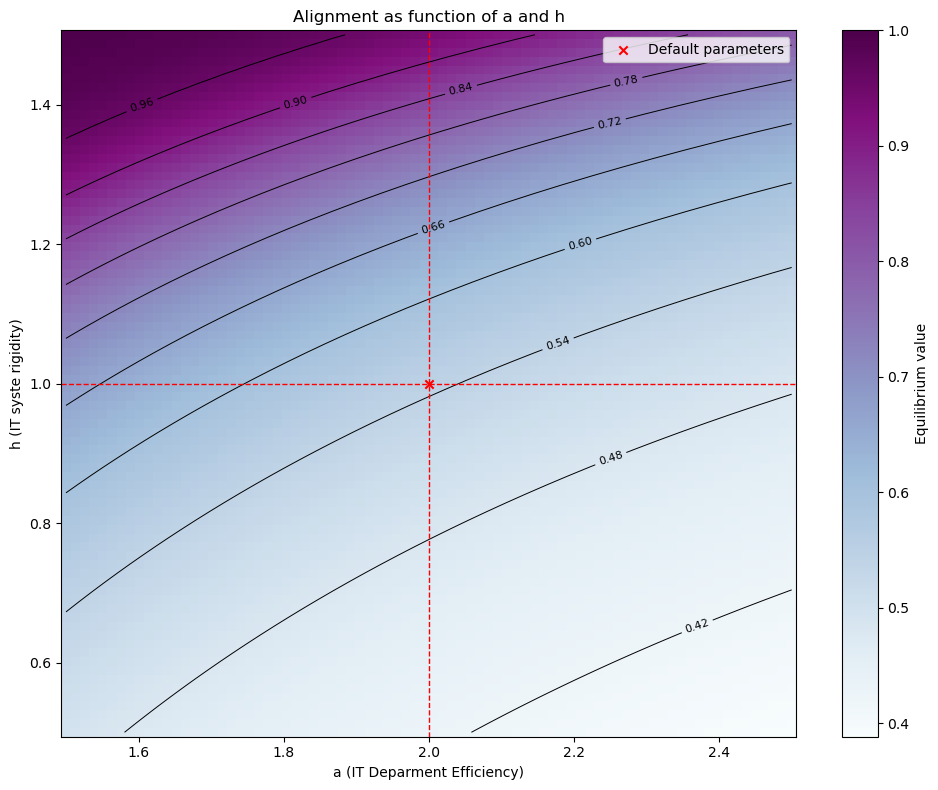

In [ ]:
delta_a_h = 0.5
a_values = np.linspace(default_params['a'] - delta_a_h, default_params['a'] + delta_a_h, 80)
h_values = np.linspace(default_params['h'] - delta_a_h, default_params['h'] + delta_a_h, 80)

A_grid, H_grid = np.meshgrid(a_values, h_values) # Combines all the values
equilibrium_values = np.zeros_like(A_grid)

# Plotting the average of the last 10 steps. 
for i in range(len(a_values)):
    for j in range(len(h_values)):
        output = simulate(
            x0=default_params['x0'],
            d=default_params['d'],
            a=A_grid[j, i],
            h=H_grid[j, i],
            g=default_params['g'],
            r=default_params['r'],
            s=default_params['s'],
            steps=default_params['steps']
        )
        equilibrium_values[j, i] = np.mean(output[-10:])  
        
plt.figure(figsize=(10, 8))

contour = plt.contour(A_grid, H_grid, equilibrium_values, 
                     levels=10, colors='black', linewidths=0.7, alpha=1)
plt.clabel(contour, inline=True, fontsize=8)

norm = Normalize(vmin=np.min(equilibrium_values), 
                vmax=1)

plt.pcolormesh(A_grid, H_grid, equilibrium_values, 
              shading='auto', cmap=plt.cm.BuPu, norm = norm)

cbar = plt.colorbar()
cbar.set_label('Alignment')

plt.axhline(y=default_params['h'], color='red', linestyle='--', linewidth=1)
plt.axvline(x=default_params['a'], color='red', linestyle='--', linewidth=1)

plt.scatter(default_params['a'], default_params['h'], 
           color='red', marker='x', label='Default parameters')

plt.xlabel('a (IT Deparment Efficiency)')
plt.ylabel('h (IT syste rigidity)')
plt.title('Alignment as function of a and h')
plt.legend()

plt.tight_layout()
plt.show()


# Is my equation chaotic?

In [ ]:
default_params = {
    'a': 2.0, 'h': 0.3, 'g': 0.2, 'r': 2, 's': 1.0
}

def bifurcation_diagram(a, h, g, r, s):
    d_values = np.linspace(0.5, 2.0, 1000)
    n_last = 100
    n_transient = 200

    plt.figure(figsize=(12, 7))

    for d in d_values:
        x = 0.5
        
        for _ in range(n_transient):
            x = np.clip(x + delta(x, d, a, h, g, r, s), 0, 1)
        
        x_vals = []
        for _ in range(n_last):
            x = np.clip(x + delta(x, d, a, h, g, r, s), 0, 1)
            x_vals.append(x)
        
        plt.plot([d] * len(x_vals), x_vals, 'k.', markersize=0.5, alpha=0.6)

    plt.title(f"Bifurcation Diagram", fontsize=14)
    plt.xlabel("Alignment Pressure (d)", fontsize=12)
    plt.ylabel("Long-term x value", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('bif_diag.png') # Saving figure
    plt.show()

@interact(
    a=FloatSlider(min=0, max=5, step=0.1, value=default_params['a'], description='a'),
    h=FloatSlider(min=0, max=2, step=0.1, value=default_params['h'], description='h'),
    g=FloatSlider(min=0, max=5, step=0.1, value=default_params['g'], description='g'),
    r=FloatSlider(min=0, max=0.5, step=0.01, value=default_params['r'], description='r'),
    s=FloatSlider(min=0, max=5, step=0.1, value=default_params['s'], description='s')
)
def update_bd(a, h, g, r, s):
    bifurcation_diagram(a, h, g, r, s)

interactive(children=(FloatSlider(value=2.0, description='a', max=5.0), FloatSlider(value=0.3, description='h'…

## TO-DO LIST
- [ ] Study other combinations of inputs.
  - ...
- [ ] Fixed point ($x_{t+1} = x_t$) analysis.  
  - Linearize with the Jacobian.  
  - If $|J| = 1$ it's a bifurcation point.  
- [ ] Study the cut-off region.